In [2]:
import os
from pathlib import Path
import yaml
import h5py
import numpy as np
import matplotlib.pyplot as plt
import torch

from ml4gw.transforms import ChannelWiseScaler
from utils.filt import BandpassFilter

from train.data import DeepCleanDataset
from train.model import DeepClean
from train.architectures import Autoencoder
from train.metrics import PsdRatio
from train.metrics import OnlinePsdRatio

from clean.frames import FrameCrawler, frame_it, parse_frame_name
from clean.data import DeepCleanInferenceDataset
from clean.model import InferenceModel
from clean.infer import OnlineInference

%matplotlib inline

In [7]:
data_dir = f"/home/chiajui.chou/deepclean/data"
training_data = f"{data_dir}/O3_AC_train_H1-1250916844.hdf5"
train_dir = f"/home/chiajui.chou/deepclean/results/train-O3-H1-kernel_1_1_st_0p5_epad_0p2_fpad_0p8_lr_0p2_oclr/lightning_logs/version_0"

with open(f"{train_dir}/config.yaml", 'r') as file:
    train_config = yaml.safe_load(file)
with open(f"{train_dir}/hparams.yaml", 'r') as file:
    train_hparams = yaml.safe_load(file)

with open(f"./config_clean.yaml", 'r') as file:
    clean_config = yaml.safe_load(file)

## Online

In [8]:
device = "cuda"
sample_rate = clean_config['sample_rate']

# InferenceModel
inference_model = InferenceModel(
    train_dir=train_dir,
    sample_rate=sample_rate,
    device=device,
)

# DeepCleanInferenceDataset
hoft_dir = clean_config['hoft_dir']
witness_dir = clean_config['witness_dir']
batch_size = 32
inference_sampling_rate = 2
kernel_size = 1
inference_dataset = DeepCleanInferenceDataset(
    hoft_dir=hoft_dir,
    witness_dir=witness_dir,
    model=inference_model,
    device=device,
)

In [9]:
print(inference_dataset.X_inference.X.shape)
print(inference_dataset.X_inference.stride)
print(inference_dataset.y_inference.X.shape)
print(inference_dataset.y_inference.stride)

torch.Size([21, 12288])
2048
torch.Size([12288])
4096


In [10]:
X_batch = next(iter(inference_dataset.X_inference))
y_batch = next(iter(inference_dataset.y_inference))
print(X_batch.shape)
print(y_batch.shape)

torch.Size([5, 21, 4096])
torch.Size([3, 4096])


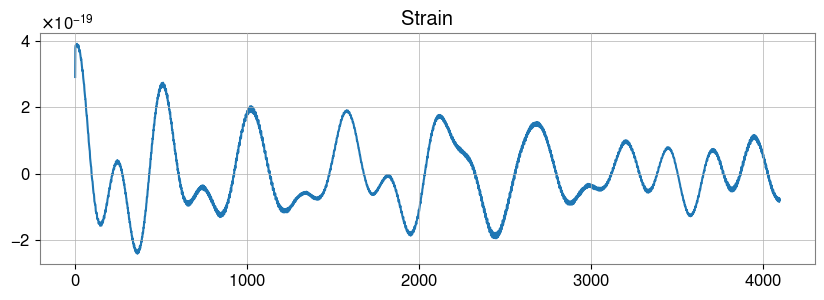

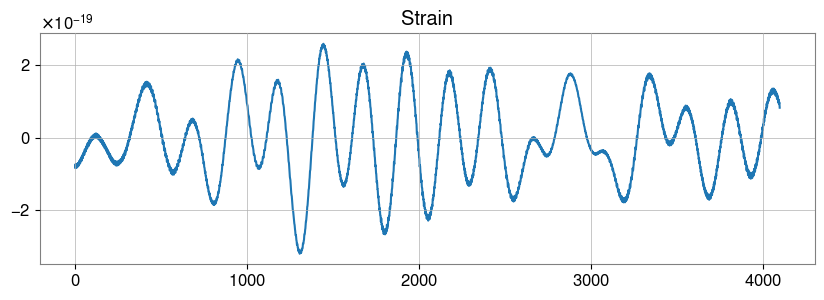

In [13]:
id = 0
plt.figure(figsize=[10,3])
plt.title('Strain')
plt.plot(y_batch[id].cpu().detach().double().numpy())
plt.show()
# plt.figure(figsize=[10,3])
# plt.title('Strain')
# plt.plot(y_batch[id+1].cpu().detach().double().numpy())
# plt.show()

# plt.figure(figsize=[10,3])
# plt.title('Predictions')
# plt.plot(metric.predictions[0][id].cpu().detach().double().numpy())
# plt.show()
# plt.figure(figsize=[10,3])
# plt.title('Predictions')
# plt.plot(metric.predictions[0][id+1].cpu().detach().double().numpy())
# plt.show()

## Offline Metrics

In [14]:
device = "cuda"
sample_rate = clean_config['sample_rate']
# Dataset
fname = train_config['data']['fname']
channels = train_config['data']['channels']
train_duration = train_config['data']['train_duration']
test_duration = train_config['data']['test_duration']
train_stride = train_config['data']['train_stride']
valid_frac = train_config['data']['valid_frac']
inference_sampling_rate = train_config['data']['inference_sampling_rate']
batch_size = train_config['data']['batch_size']
kernel_length = train_config['data']['kernel_length']
freq_low = train_config['data']['freq_low']
freq_high = train_config['data']['freq_high']
filt_order = train_config['data']['filt_order']

# Model
edge_pad = train_config['model']['metric']['init_args']['edge_pad']
filter_pad = train_config['model']['metric']['init_args']['filter_pad']
hidden_channels = train_config['model']['arch']['init_args']['hidden_channels']
num_witnesses = len(train_hparams['channels']) - 1

y_scaler = ChannelWiseScaler()
y_scaler.load_state_dict(torch.load(f"{train_dir}/y_scaler.pt"))
bandpass = BandpassFilter(
    freq_low,
    freq_high,
    sample_rate,
    filt_order
)

In [15]:
offline_dataset = DeepCleanDataset(
    fname=fname,
    channels=channels,
    kernel_length=kernel_length,
    freq_low=freq_low,
    freq_high=freq_high,
    batch_size=batch_size,
    train_duration=train_duration,
    test_duration=test_duration,
    valid_frac=valid_frac,
    train_stride=train_stride,
    inference_sampling_rate=inference_sampling_rate,
)

arch = Autoencoder(
    num_witnesses=num_witnesses,
    hidden_channels=hidden_channels,
)
loss = PsdRatio(
    sample_rate=sample_rate,
    fftlength=1,
    freq_low=freq_low,
    freq_high=freq_high,
    asd=True,
)
metric = OnlinePsdRatio(
    inference_sampling_rate=inference_sampling_rate,
    edge_pad=edge_pad,
    filter_pad=filter_pad,
    sample_rate=sample_rate,
    bandpass=bandpass,
    y_scaler=y_scaler,
)
offline_model = DeepClean(
    arch=arch,
    loss=loss,
    metric=metric,
)
model = torch.jit.load(f"{train_dir}/model.pt").to(device)

In [16]:
offline_dataset.setup(stage='fit')
offline_dataset.setup(stage='test')

In [17]:
test_dataloader = offline_dataset.test_dataloader()
print(len(test_dataloader))
print(test_dataloader.datasets[0].X.shape)
print(test_dataloader.datasets[0].kernel_size)
print(test_dataloader.datasets[0].stride)
print(test_dataloader.datasets[1].X.shape)
print(test_dataloader.datasets[1].kernel_size)
print(test_dataloader.datasets[1].stride)

print("All batches")
print("Witnesses:")
for witnesses, strain in iter(test_dataloader):
    print(witnesses.shape)

print("Strain:")
for witnesses, strain in iter(test_dataloader):
    if strain != None:
        print(strain.shape)
    else:
        print("All strain loaded.")

8
torch.Size([21, 33554432])
4096
2048
torch.Size([1, 33554432])
4096
4096
All batches
Witnesses:
torch.Size([2048, 21, 4096])
torch.Size([2048, 21, 4096])


torch.Size([2048, 21, 4096])
torch.Size([2048, 21, 4096])
torch.Size([2048, 21, 4096])
torch.Size([2048, 21, 4096])
torch.Size([2048, 21, 4096])
torch.Size([2047, 21, 4096])
Strain:
torch.Size([2048, 1, 4096])
torch.Size([2048, 1, 4096])
torch.Size([2048, 1, 4096])
torch.Size([2048, 1, 4096])
All strain loaded.
All strain loaded.
All strain loaded.
All strain loaded.


In [18]:
# offline_model._shared_eval_step, but using model from torch.jit.load.
batch = next(iter(test_dataloader))
y_true = batch[1]
print(y_true[:, 0].shape)
y_pred = offline_model(batch[0])
metric.update(y_true[:, 0], "strain")
metric.update(y_pred, "predictions")

torch.Size([2048, 4096])


In [29]:
print(metric.strain[0].shape)
print(metric.predictions[0].shape)

# id = 1
# off_id = id + 2
# plt.figure(figsize=[10,3])
# plt.title('Offline Strain')
# plt.plot(metric.strain[0][off_id].cpu().detach().double().numpy())
# plt.show()
# plt.figure(figsize=[10,3])
# plt.title('Online Strain')
# plt.plot(y_batch[id].cpu().detach().double().numpy())
# plt.show()
# plt.figure(figsize=[10,3])
# plt.title('Strain')
# plt.plot(metric.strain[0][id+1].cpu().detach().double().numpy())
# plt.show()

# plt.figure(figsize=[10,3])
# plt.title('Predictions')
# plt.plot(metric.predictions[0][id].cpu().detach().double().numpy())
# plt.show()
# plt.figure(figsize=[10,3])
# plt.title('Predictions')
# plt.plot(metric.predictions[0][id+1].cpu().detach().double().numpy())
# plt.show()

sum([i.numel() for i in metric.strain])

torch.Size([2048, 4096])
torch.Size([2048, 4096])


8388608

In [33]:
print(sum([i.numel() for i in inference_dataset.y_inference]))
print(len(inference_dataset.y_inference.X))

12288
12288
